In [71]:
#Importing Libraries


import pandas as pd
import glob
import os
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#This code defines a function called read_zipfile that takes a single argument filepath.
#The function expects filepath to be a path to a zip file that contains several CSV files, and it reads the CSV files 
#inside the zip file using the pandas library.

#The function renames the columns of the CSV files to more descriptive names and joins the data frames using a left join 
#on their timestamps. The resulting data frame is returned.

#The code then defines a list of folders, and for each folder it finds all the zip files inside it using the glob library.
#It then applies the read_zipfile function to each zip file to get a list of data frames, and concatenates them using 
#pd.concat. The resulting data frame is stored in a variable called df.

#Finally, the code removes any rows where ibo1 column has the value of 99999.


def read_zipfile(filepath):
    print(filepath)
    with zipfile.ZipFile(filepath) as zf:
        zf.extractall()
        accelerometer = pd.read_csv('ACC.csv', index_col=None, header=0)
        blood_vol = pd.read_csv('BVP.csv', index_col=None, header=0)
        eda = pd.read_csv('EDA.csv', index_col=None, header=0)
        heart_rate = pd.read_csv('HR.csv', index_col=None, header=0)
        temp = pd.read_csv('TEMP.csv', index_col=None, header=0)

        accelerometer = accelerometer.rename(columns={accelerometer.columns[0]: 'accelerometer_X', accelerometer.columns[1]: 'accelerometer_Y', accelerometer.columns[2]: 'accelerometer_Z'})
        blood_vol = blood_vol.rename(columns={blood_vol.columns[0]: 'blood_vol'})
        eda = eda.rename(columns={eda.columns[0]: 'eda'})
        heart_rate = heart_rate.rename(columns={heart_rate.columns[0]: 'heart_rate'})      
        temp = temp.rename(columns={temp.columns[0]: 'temp'})
        
        # Function to process DataFrame with timestamp
        def process_df_with_timestamp(df):
            start_timestamp = df.iloc[0, 0]
            sample_rate = df.iloc[1, 0]
            new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
            new_df['datetime'] = [(start_timestamp + i / sample_rate) for i in range(len(new_df))]
            return new_df
        
        accelerometer = process_df_with_timestamp(accelerometer)
        blood_vol = process_df_with_timestamp(blood_vol)
        eda = process_df_with_timestamp(eda)
        heart_rate = process_df_with_timestamp(heart_rate)
        temp = process_df_with_timestamp(temp)

        # Merge the DataFrames
        joined = accelerometer.merge(eda, on='datetime', how='outer')
        joined = joined.merge(bloos_vol, on='datetime', how='outer')
        joined = joined.merge(heart_rate, on='datetime', how='outer')
        joined = joined.merge(temp, on='datetime', how='outer')
            
        joined.fillna(method = 'ffill', inplace = True)
        joined.fillna(method = 'ffill', inplace = True)
        joined = joined.reset_index(drop = True)
        
        os.remove('ACC.csv')
        os.remove('BVP.csv')
        os.remove('EDA.csv')
        os.remove('HR.csv')
        os.remove('TEMP.csv')
        return joined
        
        gc.collect()

folders = glob.glob(os.path.join("Stress_dataset", "*"))
files = [glob.glob(os.path.join(f, '*.zip')) for f in folders]
dfs = [read_zipfile(file) for sublist in files for file in sublist]
df = pd.concat(dfs, ignore_index=True, sort=False)

In [25]:
# Set the path to the Excel file containing survey results
survey_results_path = r'SurveyResults.xlsx'

# Read the survey results from Excel and process date-time columns
survey_data = pd.read_excel(survey_results_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_data['Stress level'].replace('na', np.nan, inplace=True)
survey_data.dropna(inplace=True)

survey_data['Start datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['Start time'].map(str))
survey_data['End datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['End time'].map(str))
survey_data.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

# Split survey data into two parts based on daylight saving time
survey_data_part1 = survey_data[survey_data['End datetime'] <= daylight].copy()
survey_data_part1['Start datetime'] = survey_data_part1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_data_part1['End datetime'] = survey_data_part1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_data_part2 = survey_data.loc[survey_data['End datetime'] > daylight].copy()
survey_data_part2['Start datetime'] = survey_data_part2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_data_part2['End datetime'] = survey_data_part2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_data = pd.concat([survey_data_part1, survey_data_part2], ignore_index=True)
survey_data['duration'] = survey_data['End datetime'] - survey_data['Start datetime']

# Define a function to calculate duration in minutes
def calculate_duration_minutes(duration):
    return duration.seconds / 60

survey_data['duration_minutes'] = survey_data['duration'].apply(calculate_duration_minutes)

survey_data.reset_index(drop=True, inplace=True)

# Convert the 'datetime' column in 'final_data' to datetime64 type
data['datetime'] = pd.to_datetime(data['datetime'])

# Convert the 'id' column in 'final_data' and 'ID' column in 'survey_data' to string data type
data['id'] = data['id'].astype(str)

# Define a function to label rows in 'final_data' as 1 or 0 based on the 'datetime' column
def label_data(row_datetime):
    max_datetime = survey_data['End datetime'].max()
    if row_datetime >= max_datetime:
        return 1
    else:
        return 0

# Apply the 'label_data' function to the 'datetime' column in 'final_data' and assign the result to a new 'Label' column
data['Label'] = data['datetime'].apply(label_data)
df = data.copy()

df.to_csv('data.csv')

In [53]:
df = pd.read_csv('Data.csv')

In [54]:
survey_data

,ID,Stress level,Start datetime,End datetime,duration,duration_minutes
0,5C,1.0,2020-04-15 13:00:00,2020-04-15 14:00:00,0 days 01:00:00,60.0
1,5C,1.0,2020-04-14 22:31:00,2020-04-14 22:58:00,0 days 00:27:00,27.0
2,E4,2.0,2020-04-18 20:32:00,2020-04-18 20:37:00,0 days 00:05:00,5.0
3,E4,2.0,2020-04-18 19:05:00,2020-04-18 19:11:00,0 days 00:06:00,6.0
4,7A,2.0,2020-04-18 18:52:00,2020-04-18 19:03:00,0 days 00:11:00,11.0
...,...,...,...,...,...,...
240,83,2.0,2020-12-13 05:05:00,2020-12-13 05:50:00,0 days 00:45:00,45.0
241,83,2.0,2020-12-13 06:12:00,2020-12-13 08:01:00,0 days 01:49:00,109.0
242,83,2.0,2020-12-12 02:34:00,2020-12-12 02:48:00,0 days 00:14:00,14.0
243,83,2.0,2020-12-12 02:54:00,2020-12-12 03:13:00,0 days 00:19:00,19.0


In [55]:
df

,Unnamed: 0,accelerometer_X,accelerometer_Y,accelerometer_Z,id,datetime,EDA,BVP,temp,heart_rate,Label
0,0,-27.0,4.0,56.0,15,32.000000,0.185782,-0.00,31.11,95.98,0
1,1,-26.0,4.0,57.0,15,31.969697,0.185782,-0.00,31.11,95.98,0
2,2,-32.0,1.0,59.0,15,31.939394,0.185782,-0.00,31.11,95.98,0
3,3,-37.0,0.0,57.0,15,31.909091,0.185782,-0.00,31.11,95.98,0
4,4,-37.0,-1.0,54.0,15,31.878788,0.185782,-0.00,31.11,95.98,0
...,...,...,...,...,...,...,...,...,...,...,...
27564630,819642,-10.0,-59.0,22.0,15,94.867470,0.278333,-23.27,32.16,93.75,0
27564631,819643,-10.0,-59.0,22.0,15,94.879518,0.278333,-23.27,32.16,94.52,0
27564632,819644,-10.0,-59.0,22.0,15,94.891566,0.278333,-23.27,32.16,95.30,0
27564633,819645,-10.0,-59.0,22.0,15,94.903614,0.278333,-23.27,32.16,96.02,0


In [56]:
df.drop('Unnamed: 0',axis = 1,inplace = True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27564635 entries, 0 to 27564634
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   accelerometer_X  float64
 1   accelerometer_Y  float64
 2   accelerometer_Z  float64
 3   id               int64  
 4   datetime         float64
 5   EDA              float64
 6   BVP              float64
 7   temp             float64
 8   heart_rate       float64
 9   Label            int64  
dtypes: float64(8), int64(2)
memory usage: 2.1 GB


In [58]:
#Get Data Imbalance status 0 to 1 ratio
df['Label'].value_counts()

0    25736530
1     1828105
Name: Label, dtype: int64

In [59]:
#Upsampling the data

#code concatenates the zero_values and one_values DataFrames using the pd.concat method, 
#creating a new DataFrame for upsampling. The ignore_index argument is set to True to reset the index of the 
#concatenated DataFrame. This results in a new DataFrame that has roughly equal numbers of rows where the target 
#column is 0 or 1.
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

zero_values = df[df['Label'] == 0]
one_values = df[df['Label'] == 1]

X = df.drop({'Label','datetime'},axis = 1)
Y = df['Label']   
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=5)

sm = SMOTE()   
dependent, label = sm.fit_resample(X_train, y_train.ravel())
print("UpSampling 1:- {}".format(sum(label==1)))

UpSampling 1:- 18015542


In [60]:
DF = dependent.copy()
DF['Label'] = label

In [62]:
#This code returns a tuple containing the shapes of two DataFrames zero_values and one_values. The shape attribute of a 
#DataFrame returns a tuple representing the number of rows and columns in the DataFrame.

zero_values.shape, one_values.shape

((25736530, 10), (1828105, 10))

In [63]:
DF['Label'].value_counts()

0    18015542
1    18015542
Name: Label, dtype: int64

In [65]:
#This code computes the correlation matrix for the downsampled DataFrame df_after_downsampling using the corr() method of a 
#pandas DataFrame. The transpose() method is then called on the result to obtain a transposed version of the correlation 
#matrix, which is a symmetric matrix of pairwise correlations between all pairs of features in the DataFrame.

#The resulting corr_metric DataFrame has the same number of rows and columns as df_after_downsampling, where each row and 
#column represents a feature, and each cell contains the correlation coefficient between the corresponding pair of features.
#The correlation coefficient is a measure of the strength and direction of the linear relationship between two variables, 
#and ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

corr_metric = DF.corr().transpose()

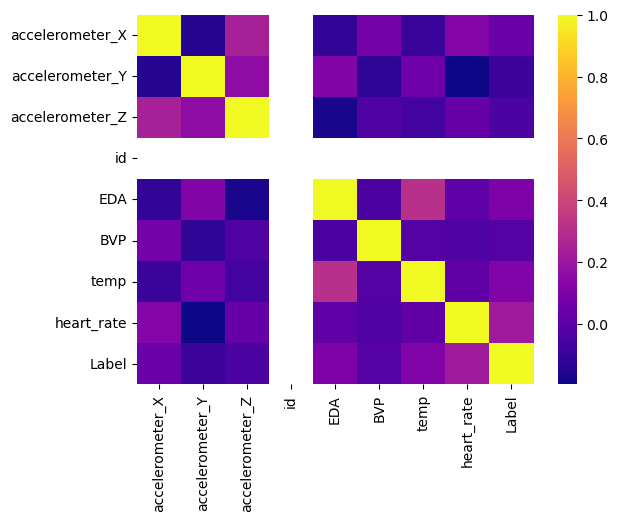

In [66]:
#This code visualizes the correlation matrix computed in the previous step using the heatmap function from the seaborn library
#The cmap argument specifies the color map to use for the heatmap, in this case 'plasma', which ranges from purple to yellow

sns.heatmap(corr_metric, cmap='plasma')
plt.show()

In [8]:
#This code simply assigns the downsampled DataFrame df_after_downsampling to a new variable named final. The new variable 
#final now references the downsampled DataFrame with the target variable balanced between the two classes. 
#This code assigns the value of the "df_after_downsampling" dataframe to the variable "final".

final = DF

array([[<AxesSubplot:title={'center':'accelerometer_X'}>,
        <AxesSubplot:title={'center':'accelerometer_Y'}>,
        <AxesSubplot:title={'center':'accelerometer_Z'}>],
       [<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'EDA'}>,
        <AxesSubplot:title={'center':'BVP'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'heart_rate'}>,
        <AxesSubplot:title={'center':'Label'}>]], dtype=object)

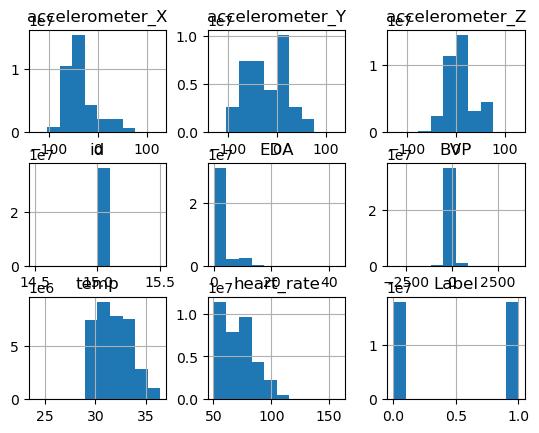

In [69]:
final.hist()

In [70]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36031084 entries, 0 to 36031083
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   accelerometer_X  float64
 1   accelerometer_Y  float64
 2   accelerometer_Z  float64
 3   id               int64  
 4   EDA              float64
 5   BVP              float64
 6   temp             float64
 7   heart_rate       float64
 8   Label            int64  
dtypes: float64(7), int64(2)
memory usage: 2.4 GB


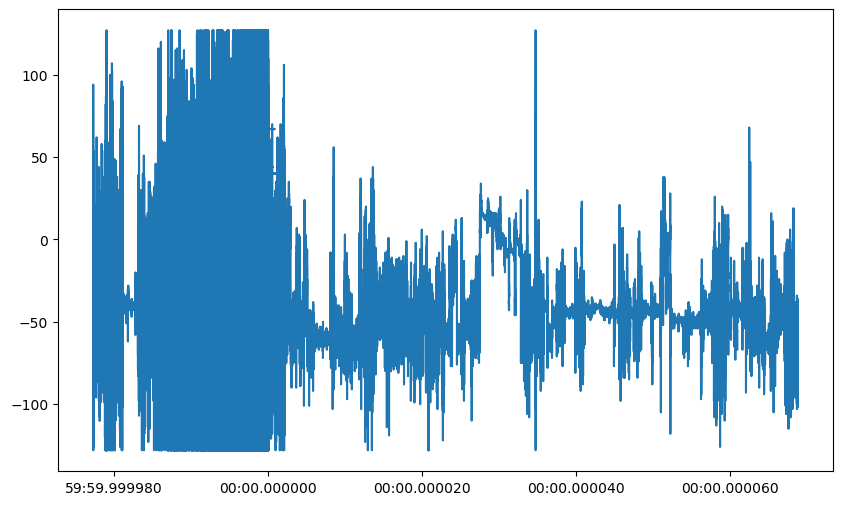

In [9]:
# Plot the timeseries data
plt.figure(figsize=(10, 6))
print(plt.plot(final.datetime, final.accelerometer_X))

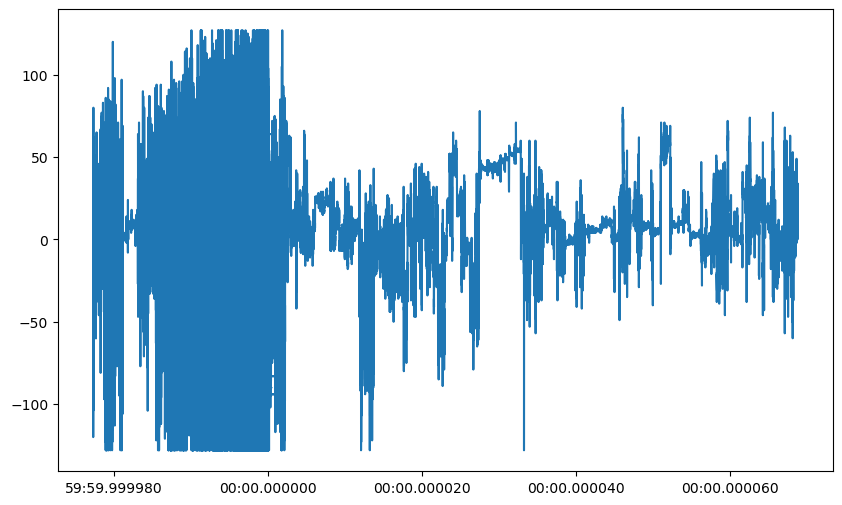

In [11]:
# Plot the timeseries data
plt.figure(figsize=(10, 6))
print(plt.plot(final.datetime, final.accelerometer_Y))

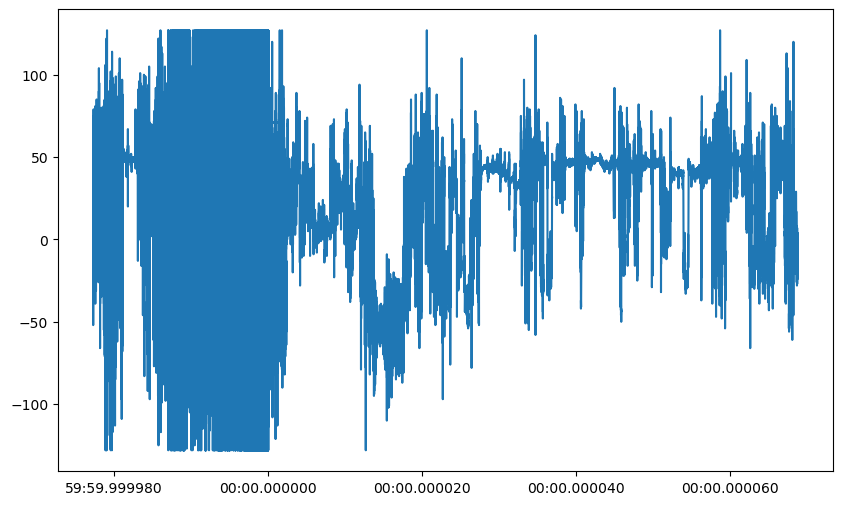

In [13]:
# Plot the timeseries data
plt.figure(figsize=(10, 6))
print(plt.plot(final.datetime, final.accelerometer_Z))

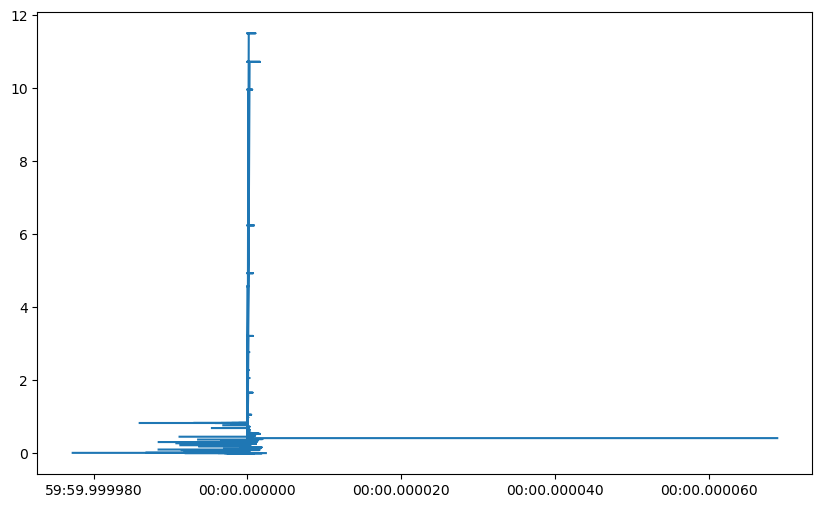

In [14]:
# Plot the timeseries data
plt.figure(figsize=(10, 6))
print(plt.plot(final.datetime, final.EDA))

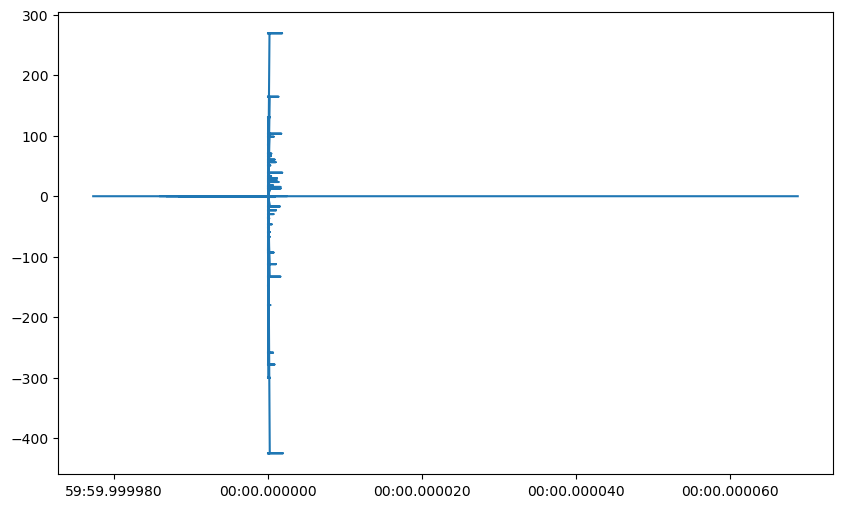

In [15]:
# Plot the timeseries data
plt.figure(figsize=(10, 6))
print(plt.plot(final.datetime, final.BVP))

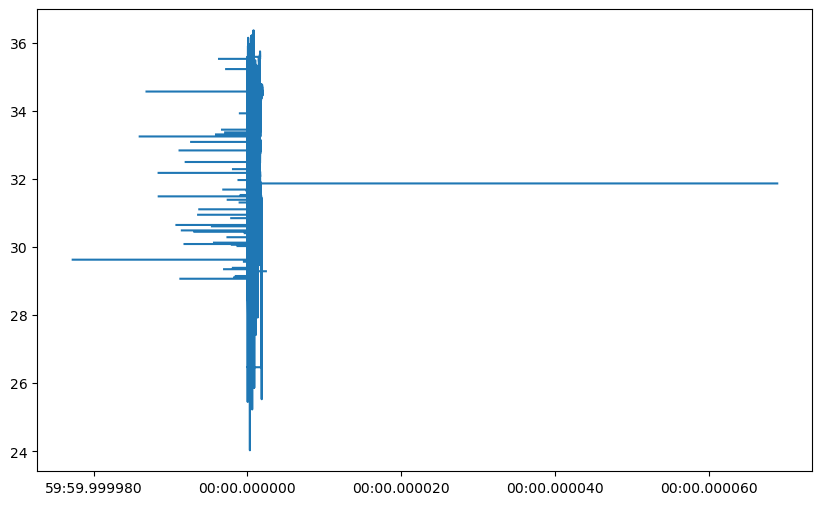

In [16]:
# Plot the timeseries data
plt.figure(figsize=(10, 6))
print(plt.plot(final.datetime, final.temp))

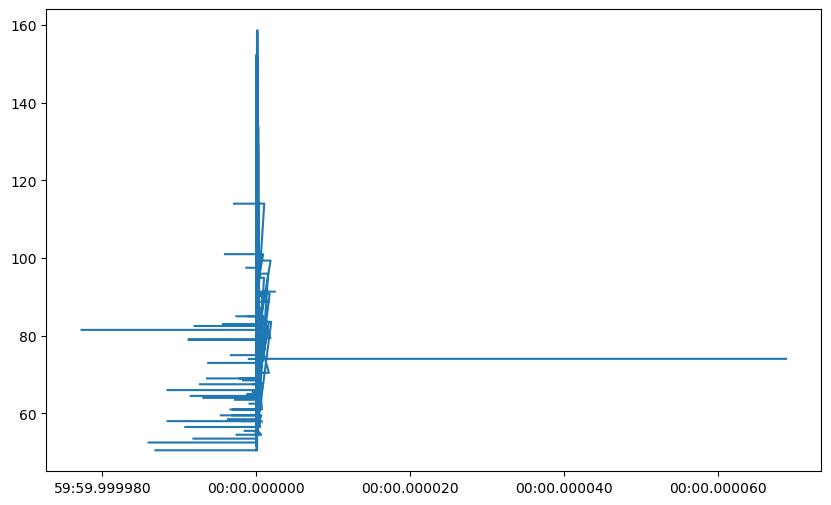

In [17]:
# Plot the timeseries data
plt.figure(figsize=(10, 6))
print(plt.plot(final.datetime, final.heart_rate))

# Train-Test-Split

In [73]:
#splitting data manually by 75% and 25%
train = final.iloc[:int(final.shape[0] * 0.75)]
test = final.iloc[int(final.shape[0] * 0.75):]

X_train = train.drop({'Label'}, axis=1)
y_train = train['Label']
X_test = test.drop({'Label'}, axis=1)
y_test = test['Label']

# Output the shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(27023313, 8) (27023313,) (9007771, 8) (9007771,)


# Standadization

In [76]:
from sklearn.preprocessing import StandardScaler

X_train_features = X_train
X_test_features = X_test

# Standar Scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_features)

X_test_scaled = scaler.transform(X_test_features)

# MODEL Building

# LogisticRegression

In [74]:
#This code loads data into a pandas dataframe, splits it into training and testing sets, and trains a logistic regression 
#model to predict the target variable. The model's accuracy is evaluated using the accuracy score.

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the data into a pandas dataframe
# Instantiate the Logistic Regression classifier
lr = LogisticRegression(random_state=42)

# Train the model on the training data
lr.fit(X_train_scaled, y_train)

# Predict the target variable for the test data
y_pred = lr.predict(X_test_scaled)

# Evaluate the performance of the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.6014591179105242


In [75]:
#This code imports the classification_report function from sklearn.metrics, which is used to generate a report that 
#displays the precision, recall, F1 score, and support for each class in the model's predictions on the test set
#The report helps evaluate the model's performance.

from sklearn.metrics import classification_report

# Print classification report for the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.66      0.62   4504611
           1       0.61      0.55      0.58   4503160

    accuracy                           0.60   9007771
   macro avg       0.60      0.60      0.60   9007771
weighted avg       0.60      0.60      0.60   9007771



# Random FOrest

In [75]:
# Load the data into a pandas dataframe
# Instantiate the Random FOrest classifier
RF = RandomForestClassifier()

# Train the model on the training data
RF.fit(X_train_scaled, y_train)

# Predict the target variable for the test data
y_pred = RF.predict(X_test_scaled)

# Evaluate the performance of the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8047563948


In [74]:
#This code imports the classification_report function from sklearn.metrics, which is used to generate a report that 
#displays the precision, recall, F1 score, and support for each class in the model's predictions on the test set
#The report helps evaluate the model's performance.

from sklearn.metrics import classification_report

# Print classification report for the model
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support
                                                      
           0        0.77      0.86      0.81   4504611
           1        0.84      0.75      0.79   4503160
                                                      
    accuracy                            0.80   9007771
   macro avg        0.81      0.80      0.80   9007771
weighted avg        0.81      0.80      0.80   9007771


# Adaboost classifier

In [76]:
from sklearn.ensemble import AdaBoostClassifier

In [77]:
# Load the data into a pandas dataframe
# Instantiate the Random FOrest classifier
AD = AdaBoostClassifier()

# Train the model on the training data
AD.fit(X_train_scaled, y_train)

# Predict the target variable for the test data
y_pred = AD.predict(X_test_scaled)

# Evaluate the performance of the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accurcy: 0.735647563948


In [78]:
#This code imports the classification_report function from sklearn.metrics, which is used to generate a report that 
#displays the precision, recall, F1 score, and support for each class in the model's predictions on the test set
#The report helps evaluate the model's performance.

from sklearn.metrics import classification_report

# Print classification report for the model
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support
                                                      
           0        0.72      0.73      0.74   4504611
           1        0.73      0.72      0.74   4503160
                                                      
    accuracy                            0.74   9007771
   macro avg        0.72      0.72      0.74   9007771
weighted avg        0.72      0.72      0.74   9007771
